In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os



In [3]:
# print("")
meta = pd.read_csv("../../data/meta_all_gene.csv")

####  Create a separate CSV file to extract the slide name and involve_cancer data from the metadata file.

In [4]:
# import pandas as pd

def save_slides(meta):
    # Define file path
    
    slide_dir = os.path.join("../../data/slide_info")  
    os.makedirs(slide_dir, exist_ok=True)
    tissue_counts = meta['tissue'].value_counts()
    valid_tissues = tissue_counts[tissue_counts > 15].index
    filtered_meta = meta[meta['tissue'].isin(valid_tissues)]

    # Get unique tissues
    tissues = filtered_meta['tissue'].unique()

    # Loop through each tissue and save its slide info
    for tissue in tissues:
        # Filter metadata for the current tissue
        filtered_meta = meta[meta['tissue'] == tissue][['slide', 'involve_cancer']]

        # Save to CSV
        file_path = f"{slide_dir}/{tissue}_slide_info.csv"
        filtered_meta.to_csv(file_path, index=False)

        print(f"$ Slide file created: {file_path}")

# Example usage
save_slides(meta)  # Assuming `meta` is your metadata DataFrame


$ Slide file created: ../../data/slide_info/skin_slide_info.csv
$ Slide file created: ../../data/slide_info/breast_slide_info.csv
$ Slide file created: ../../data/slide_info/heart_slide_info.csv
$ Slide file created: ../../data/slide_info/brain_slide_info.csv
$ Slide file created: ../../data/slide_info/colon_slide_info.csv
$ Slide file created: ../../data/slide_info/kidney_slide_info.csv
$ Slide file created: ../../data/slide_info/ovary_slide_info.csv
$ Slide file created: ../../data/slide_info/liver_slide_info.csv
$ Slide file created: ../../data/slide_info/glioma_slide_info.csv
$ Slide file created: ../../data/slide_info/pancreas_slide_info.csv
$ Slide file created: ../../data/slide_info/spleen_slide_info.csv
$ Slide file created: ../../data/slide_info/mouth_slide_info.csv
$ Slide file created: ../../data/slide_info/root_slide_info.csv
$ Slide file created: ../../data/slide_info/prostate_slide_info.csv


### Gene Pre Processing

In [5]:
output_dir = "../../data/gene_analyses/brain"
os.makedirs(output_dir, exist_ok=True)
# Path to gene expression files
gene_exp_dir = "../../data/Visium/gene_exp"


##### Separate cancerous and healthy slides

In [6]:
# Load brain slides info
brain_slides = pd.read_csv("../../data/slide_info/brain_slide_info.csv")

# Separate cancerous and healthy slides
cancer_slides = brain_slides[brain_slides["involve_cancer"] == True]["slide"]
healthy_slides = brain_slides[brain_slides["involve_cancer"] == False]["slide"]


#### Determine the number of cancerous and healthy slides downloaded.

C:\Users\asus\AppData\Local\Temp\ipykernel_22876\2988079446.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y="Count", data=slide_counts, palette=["red", "green"])


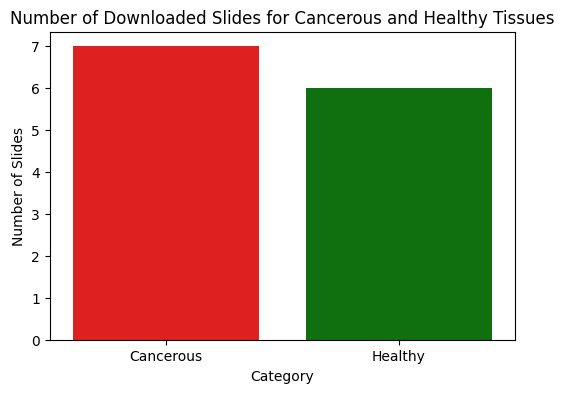

✅ Cancerous slides: 7, Healthy slides: 6


In [7]:
# Extract downloaded slide names (remove file extensions)
downloaded_slides = {f.split("_count.csv")[0] for f in os.listdir(gene_exp_dir) if f.endswith("_count.csv")}

# Filter metadata to include only slides that were actually downloaded
filtered_slides = brain_slides[brain_slides["slide"].isin(downloaded_slides)]

# Ensure 'involve_cancer' column exists
if "involve_cancer" not in filtered_slides.columns:
    raise ValueError("Error: The metadata file does not contain 'involve_cancer' column!")

# Count cancerous and healthy slides
num_cancerous = filtered_slides["involve_cancer"].sum()
num_healthy = len(filtered_slides) - num_cancerous

# Create a DataFrame for visualization
slide_counts = pd.DataFrame({"Category": ["Cancerous", "Healthy"], "Count": [num_cancerous, num_healthy]})

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x="Category", y="Count", data=slide_counts, palette=["red", "green"])
plt.title("Number of Downloaded Slides for Cancerous and Healthy Tissues")
plt.ylabel("Number of Slides")
plt.show()

print(f"✅ Cancerous slides: {num_cancerous}, Healthy slides: {num_healthy}")

### Step1: Compute Average Gene Expression for Each Group
In this step, we calculate the average expression levels of each gene separately for cancerous and healthy tissue samples. This helps us summarize the expression data. The resul
ts are two files one for cancerous and one for health tissues that contain the gene and the mean of the activity of this gene in all available slides of this part.

* #### Function to compute average gene expression for a given slide

In [8]:

def compute_avg_expression(slide_name):
    file_path = os.path.join(gene_exp_dir, f"{slide_name}_count.csv")
    
    if not os.path.exists(file_path):
        return None  

    df = pd.read_csv(file_path, index_col=0)  
    avg_expression = df.mean(axis=0)

    return avg_expression

* #### Calculate the average gene expression per slide.

In [9]:
# Define input directories
output_dir = "../../data/gene_analyses/brain/gen_exp_avg"
os.makedirs(output_dir, exist_ok=True)

In [13]:


# Dictionaries to store per-slide gene expression
cancerous_dict = {}
healthy_dict = {}

# Loop through each slide and compute average expression
for _, row in brain_slides.iterrows():
    slide_name = row["slide"]
    is_cancerous = row["involve_cancer"]  # True = cancerous, False = healthy
    
    # Compute average gene expression for the slide
    avg_expression = compute_avg_expression(slide_name)
    
    if avg_expression is not None:
        if is_cancerous:
            cancerous_dict[slide_name] = avg_expression  # Store per-slide result
        else:
            healthy_dict[slide_name] = avg_expression  # Store per-slide result

# Convert per-slide data to DataFrames
cancerous_df = pd.DataFrame(cancerous_dict)
healthy_df = pd.DataFrame(healthy_dict)

# Save per-slide gene expression files
cancerous_df.to_csv(os.path.join(output_dir, "cancerous_per_slide_gene_expression.csv"))
healthy_df.to_csv(os.path.join(output_dir, "healthy_per_slide_gene_expression.csv"))

print("✅ Per-slide gene expression saved for cancerous and healthy samples.")


✅ Per-slide gene expression saved for cancerous and healthy samples.


In [14]:
# Load per-slide gene expression data
cancerous_per_slide = pd.read_csv("../../data/gene_analyses/brain/gen_exp_avg/cancerous_per_slide_gene_expression.csv", index_col=0)
healthy_per_slide = pd.read_csv("../../data/gene_analyses/brain/gen_exp_avg/healthy_per_slide_gene_expression.csv", index_col=0)

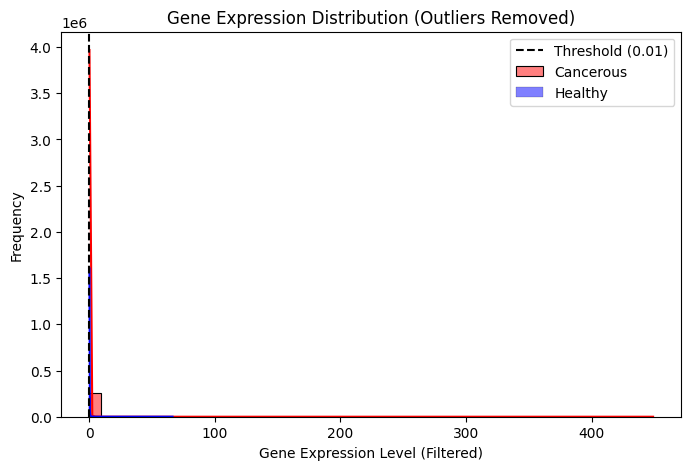

In [15]:
# Flatten expression values and remove outliers (exp > 10)
filtered_cancerous = cancerous_per_slide.values.flatten()
filtered_healthy = healthy_per_slide.values.flatten()

filtered_cancerous = filtered_cancerous[filtered_cancerous <= 1000]
filtered_healthy = filtered_healthy[filtered_healthy <= 1000]

plt.figure(figsize=(8, 5))
sns.histplot(filtered_cancerous, bins=50, kde=True, color="red", label="Cancerous")
sns.histplot(filtered_healthy, bins=50, kde=True, color="blue", label="Healthy")
plt.axvline(x=0.01, color="black", linestyle="dashed", label="Threshold (0.01)")
plt.xlabel("Gene Expression Level (Filtered)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Gene Expression Distribution (Outliers Removed)")
plt.show()

In [16]:
min_nonzero_expression = np.percentile(np.concatenate((filtered_cancerous[filtered_cancerous > 0], 
                                                       filtered_healthy[filtered_healthy > 0])), 5)
print(f"Suggested threshold: {min_nonzero_expression:.5f}")


Suggested threshold: 0.00043


* #### Filtering Low-Presence Genes Based on Expression Threshold.
 I dropped the genes that has a value less than 0.01 and didn't appear in 90% of the of the total slides i have 

In [18]:
# Define minimum threshold for presence (adjustable)
MIN_EXPRESSION_THRESHOLD = 0.01  # Values below this are considered absent

# Apply threshold for presence detection
cancerous_presence = (cancerous_per_slide >= MIN_EXPRESSION_THRESHOLD).astype(int)
healthy_presence = (healthy_per_slide >= MIN_EXPRESSION_THRESHOLD).astype(int)

# Count how many slides each gene appears in
cancerous_presence_count = cancerous_presence.sum(axis=1)
healthy_presence_count = healthy_presence.sum(axis=1)

# Calculate presence percentage across slides
cancerous_percentage = cancerous_presence_count / cancerous_per_slide.shape[1]
healthy_percentage = healthy_presence_count / healthy_per_slide.shape[1]

# Define a presence threshold (genes appearing in ≤5% of slides are considered absent)
PRESENCE_THRESHOLD = 0.1 

# Select genes appearing in very few slides
selected_cancerous_genes = cancerous_percentage[cancerous_percentage <= PRESENCE_THRESHOLD].index
selected_healthy_genes = healthy_percentage[healthy_percentage <= PRESENCE_THRESHOLD].index

# Store in DataFrames
selected_cancerous_genes_df = pd.DataFrame(selected_cancerous_genes, columns=["Gene"])
selected_healthy_genes_df = pd.DataFrame(selected_healthy_genes, columns=["Gene"])

# Save to CSV (optional)
# selected_cancerous_genes_df.to_csv(f"{output_dir}/selected_cancer_genes.csv", index=False)

# Display results
print(f"Total low-presence cancerous genes found: {len(selected_cancerous_genes_df)}")
print(f"Total low-presence healthy genes found: {len(selected_healthy_genes_df)}")


Total low-presence cancerous genes found: 19408
Total low-presence healthy genes found: 20991


In [19]:
selected_cancerous_genes_df.head()


,Gene
0,A1CF
1,A2ML1-AS1
2,A2ML1-AS2
3,A3GALT2
4,A4GNT


* #### Identifying Genes Absent in Both Cancerous and Healthy Samples

In [20]:

# Select genes that are completely absent (0%) in both cancerous and healthy slides
genes_absent_in_both = cancerous_percentage[(cancerous_percentage <= PRESENCE_THRESHOLD) & (healthy_percentage <= PRESENCE_THRESHOLD)].index

# Store in a DataFrame
genes_absent_in_both_df = pd.DataFrame(genes_absent_in_both, columns=["Gene"])
# Display results
print(f"Total genes absent in both cancerous and healthy slides: {len(genes_absent_in_both_df)}")
# genes_absent_in_both_df.head()

Total genes absent in both cancerous and healthy slides: 17333


* #### Removing Genes Absent in Both Conditions.

In [21]:

selected_cancerous_genes_df = selected_cancerous_genes_df.loc[
    ~selected_cancerous_genes_df["Gene"].isin(genes_absent_in_both_df["Gene"])
]
selected_healthy_genes_df = selected_healthy_genes_df.loc[
    ~selected_healthy_genes_df["Gene"].isin(genes_absent_in_both_df["Gene"])
]
# Drop genes that are absent in both from cancerous and healthy gene DataFrames

# Display results
print(f"Total cancerous genes after removal: {len(selected_cancerous_genes_df)}")
print(f"Total healthy genes after removal: {len(selected_healthy_genes_df)}")



Total cancerous genes after removal: 2075
Total healthy genes after removal: 3658


The output of the above cell is genes that is Zero average activity gene in cancerous and healthy 

In [22]:
# Paths to the files
cancerous_file = "../../data/gene_analyses/brain/gen_exp_avg/cancerous_per_slide_gene_expression.csv"
healthy_file = "../../data/gene_analyses/brain/gen_exp_avg/healthy_per_slide_gene_expression.csv"

# Load the cancerous and healthy gene expression DataFrames
average_cancerous_genes_df = pd.read_csv(cancerous_file)
average_healthy_genes_df = pd.read_csv(healthy_file)

# Check the first few rows to understand the structure
# print(average_cancerous_genes_df.head())

# Assuming genes_absent_in_both_df is already defined and contains the genes to be removed
# Drop genes that are absent in both from cancerous and healthy gene DataFrames
average_cancerous_genes_df = average_cancerous_genes_df.loc[
    ~average_cancerous_genes_df["Unnamed: 0"].isin(genes_absent_in_both_df["Gene"])
]

average_healthy_genes_df = average_healthy_genes_df.loc[
    ~average_healthy_genes_df["Unnamed: 0"].isin(genes_absent_in_both_df["Gene"])
]

# Save the updated DataFrames back to CSV
average_cancerous_genes_df.to_csv(cancerous_file, index=False)
average_healthy_genes_df.to_csv(healthy_file, index=False)

# Display results
print(f"Total cancerous genes after removal: {len(average_cancerous_genes_df)}")
print(f"Total healthy genes after removal: {len(average_healthy_genes_df)}")


Total cancerous genes after removal: 20891
Total healthy genes after removal: 19268


in the above cell we remove the genes that is absent in both cancerous and healthy and save to the file 

In [ ]:
#this is the number of the helathy genes that is zero but have a value in the cancerous cells 
len(selected_healthy_genes_df)

3658

* #### Compute and Save Overall Average Gene ExpressionCompute and Save Overall Average Gene Expression


In [24]:
# Compute overall average gene expression for cancerous slides

cancerous_avg = cancerous_df.mean(axis=1)

# Compute overall average gene expression for healthy slides
healthy_avg = healthy_df.mean(axis=1)

# Convert to DataFrames
cancerous_avg_df = pd.DataFrame(cancerous_avg, columns=["Cancerous_Expression"])
healthy_avg_df = pd.DataFrame(healthy_avg, columns=["Healthy_Expression"])

# Save overall average gene expression
cancerous_avg_df.to_csv(os.path.join(output_dir, "cancerous_avg_gene_expression.csv"))
healthy_avg_df.to_csv(os.path.join(output_dir, "healthy_avg_gene_expression.csv"))

print("✅ Overall average gene expression saved successfully!")


✅ Overall average gene expression saved successfully!


* #### Categorize gene activity into high, moderate, and low levels.

In [25]:
# Define input and output paths
output_dir = "../../data/gene_analyses/brain/gene_activity/categorized_genes"
os.makedirs(output_dir, exist_ok=True)

cancerous_file = "../../data/gene_analyses/brain/gen_exp_avg/cancerous_avg_gene_expression.csv"
healthy_file = "../../data/gene_analyses/brain/gen_exp_avg/healthy_avg_gene_expression.csv"

# Load average gene expression data
cancerous_slides = pd.read_csv(cancerous_file, index_col=0)
healthy_slides = pd.read_csv(healthy_file, index_col=0)

# Ensure both datasets have the same genes (take common genes)
common_genes = cancerous_slides.index.intersection(healthy_slides.index)
cancerous_avg = cancerous_slides.loc[common_genes]
healthy_avg = healthy_slides.loc[common_genes]

# Compute fold-change (avoid division by zero)
fold_change = (cancerous_avg.iloc[:, 0] + 1e-6) / (healthy_avg.iloc[:, 0] + 1e-6)

# Categorize genes based on fold-change
highly_active = fold_change[(fold_change >= 2) & (cancerous_avg.iloc[:, 0] >= 1.0)]
moderately_changed = fold_change[(fold_change > 1) & (fold_change < 2)]
low_change = fold_change[fold_change <= 1]

# Function to save categorized genes
def save_gene_category(category, filename):
    category_df = pd.DataFrame({
        "Gene": category.index,
        "Cancerous_Expression": cancerous_avg.loc[category.index].iloc[:, 0],
        "Healthy_Expression": healthy_avg.loc[category.index].iloc[:, 0],
        "Fold_Change": category
    })
    category_df.to_csv(f"{output_dir}/{filename}", index=False)

# Save categorized genes
save_gene_category(highly_active, "highly_active_genes.csv")
save_gene_category(moderately_changed, "moderately_changed_genes.csv")
save_gene_category(low_change, "low_change_genes.csv")

print(f"✅ Gene categorization complete. Results saved in {output_dir}.")


✅ Gene categorization complete. Results saved in ../../data/gene_analyses/brain/gene_activity/categorized_genes.


### Step 3: Apply Absolute Expression Threshold  

In this step, we refine our gene classification by applying an **absolute expression threshold**. While fold-change helps identify differences between cancerous and healthy tissues, it can sometimes highlight genes with very low expression levels, which might be biologically insignificant or due to noise.  

To address this, we set a **minimum expression threshold** and filter out genes that do not meet this criterion in cancerous tissues. This ensures that only **high-confidence, highly active genes** are considered.  

#### Process:
- Remove genes where the absolute difference between cancerous and healthy tissues is below **0.01** to avoid small fluctuations being misclassified as significant.
- Keep only genes that meet both the **2× fold-change** criterion and the **minimum expression requirement** (at least **1.0** in cancerous tissues).

By applying this filter, we focus on genes that are not just differentially expressed but also **meaningfully active in cancerous tissues**, leading to more reliable insights. The final list of **highly active genes** is updated and saved for further analysis.


In [26]:
# Load previously categorized highly active genes
highly_active_genes = pd.read_csv(f"{output_dir}/highly_active_genes.csv")

# Load cancerous and healthy tissue expression data
cancerous_slides = pd.read_csv(cancerous_file, index_col=0)
healthy_slides = pd.read_csv(healthy_file, index_col=0)

# Ensure that the gene names are correctly aligned
valid_genes = highly_active_genes["Gene"].dropna()
valid_genes = valid_genes[valid_genes.isin(cancerous_slides.index) & valid_genes.isin(healthy_slides.index)]

# Retrieve cancerous and healthy expression values
cancerous_expression = cancerous_slides.loc[valid_genes].mean(axis=1)
healthy_expression = healthy_slides.loc[valid_genes].mean(axis=1)

# Compute absolute difference
expression_difference = abs(cancerous_expression - healthy_expression)

# Apply the absolute difference threshold (≥0.01)
filtered_genes = expression_difference[expression_difference >= 0.01].index

# Save final highly active genes with expression values
filtered_genes_df = pd.DataFrame({
    "Gene": filtered_genes,
    "Cancerous_Expression": cancerous_expression.loc[filtered_genes],
    "Healthy_Expression": healthy_expression.loc[filtered_genes],
    "Expression_Difference": expression_difference.loc[filtered_genes]
})

filtered_genes_df.to_csv(f"{output_dir}/highly_active_genes.csv", index=False)

print(f"✅ Final filtered list of highly active genes saved in {output_dir}/highly_active_genes.csv")


✅ Final filtered list of highly active genes saved in ../../data/gene_analyses/brain/gene_activity/categorized_genes/highly_active_genes.csv


* #### Visualizing Gene Activity Distribution Using an Interactive Pie Chart.

In [27]:
# Load final categorized genes from Step 3
final_highly_active_genes = pd.read_csv(f"{output_dir}/highly_active_genes.csv")["Gene"]

# Compute category sizes
num_highly_active = len(final_highly_active_genes)
num_moderately_changed = len(moderately_changed)  # Already defined in Step 2
num_low_activity = len(fold_change[fold_change < 1])  # Already defined in Step 2

# Create a DataFrame for visualization
data = pd.DataFrame({
    "Category": ["Highly Active (≥2×)", "Moderately Changed (1× - 2×)", "Low Activity (<1×)"],
    "Count": [num_highly_active, num_moderately_changed, num_low_activity]
})

# Create an interactive pie chart
fig = px.pie(data, values="Count", names="Category", 
             title="Proportion of Gene Activity Categories",
             color="Category",
             color_discrete_map={"Highly Active (≥2×)": "red", 
                                 "Moderately Changed (1× - 2×)": "yellow", 
                                 "Low Activity (<1×)": "green"})

fig.show()


* #### Load and Sort Highly Active Genes by Expression Difference.

In [82]:

# Load the healthy gene expression file
healthy_file = "../../data/gene_analyses/brain/gen_exp_avg/healthy_per_slide_gene_expression.csv"
healthy_df = pd.read_csv(healthy_file)

# Identify the gene name column (usually the first column)
gene_name_column = healthy_df.columns[0]

# Extract expression values only (exclude gene name column)
expression_only = healthy_df.drop(columns=[gene_name_column])

# Calculate the expression range for each gene
healthy_df["Expression_Range"] = expression_only.max(axis=1) - expression_only.min(axis=1)

# Sort by Expression_Range descending
sorted_df = healthy_df.sort_values(by="Expression_Range", ascending=False)

# Display the top 10 (or however many you want)
print(sorted_df[[gene_name_column, "Expression_Range"]].head(100))

      Unnamed: 0  Expression_Range
19248     MT-CO2         44.758466
19247     MT-CO1         33.462943
19251     MT-CO3         32.680648
19245     MT-ND1         32.213611
19250    MT-ATP6         31.226902
...          ...               ...
12170      RPL21          4.079553
13475        PKM          4.062758
4278      EIF4A2          4.026314
13115     SNHG14          4.007074
5379        ENC1          4.002759

[100 rows x 2 columns]


In [94]:
# Count the number of genes in each range group
range_counts = healthy_df["Range_Group"].value_counts().sort_index()

# Print the counts
print("Gene counts per Expression_Range group:")
print(range_counts)


Gene counts per Expression_Range group:
Range_Group
0–5    19207
+5        61
Name: count, dtype: int64


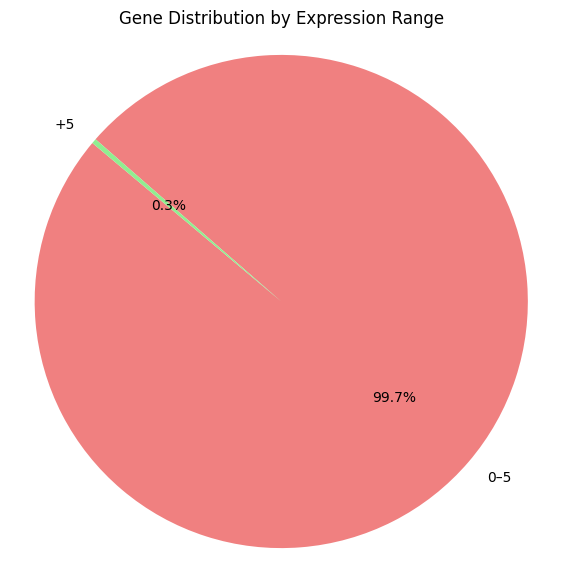

In [120]:
# Plot pie chart for gene distribution across bins
plt.figure(figsize=(7, 7))
plt.pie(range_counts, labels=range_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightgreen'])
plt.title("Gene Distribution by Expression Range")
plt.axis('equal')
plt.show()


this genes has a huge difference betweeen the min and max value in the healthy tissues 

In [96]:
# Get the count of genes in the '+5' category
n = range_counts.get('+5', 0)  # Default to 0 if '+5' is not found

# Print the value of n
print("Number of genes with Expression_Range > 5:", n)


Number of genes with Expression_Range > 5: 61


In [97]:
healthy_unusual_genes=sorted_df[[gene_name_column, "Expression_Range"]].head(n)

In [122]:
output_dir = "../../data/gene_analyses/brain/gene_activity/categorized_genes"

# Load the final highly active genes file
final_highly_active_genes = pd.read_csv(f"{output_dir}/highly_active_genes.csv")

# Filter out genes with Expression_Difference less than 5
final_highly_active_genes = final_highly_active_genes[final_highly_active_genes["Expression_Difference"] > 5]

# Sort by Expression_Difference (descending order)
final_highly_active_genes = final_highly_active_genes.sort_values(by="Expression_Difference", ascending=False)

# Display the top 50 rows only
display(final_highly_active_genes.head(10))

# Show the total number of genes after filtering
print(f"Remaining genes after filtering: {len(final_highly_active_genes)}")

,Gene,Cancerous_Expression,Healthy_Expression,Expression_Difference
258,IGKC,120.051583,0.005174,120.046409
320,MT-CO2,113.154734,40.544156,72.610578
326,MT2A,69.135796,1.957594,67.178201
321,MT-CO3,98.601141,37.846820,60.754321
255,IGHG4,48.980617,0.000387,48.980230
524,S100A6,45.684560,0.695077,44.989483
254,IGHG3,44.299743,0.000145,44.299599
323,MT-ND4,68.138247,27.972665,40.165582
621,TMSB10,44.012013,8.189061,35.822952
182,FTL,35.470944,4.028604,31.442341


Remaining genes after filtering: 141


In [103]:
# Select top 20 highly active genes for better readability
top_n = 20
top_genes = final_highly_active_genes.head(top_n)

# Create a bar chart
fig = px.bar(top_genes, x="Gene", y="Expression_Difference", 
             title=f"Top {top_n} Highly Active Genes",
             labels={"Expression_Difference": "Expression Difference"},
             color="Expression_Difference",
             color_continuous_scale="Reds")

fig.show()

In [ ]:
# Load the data (final_low_active_genes file)
final_low_active_genes = pd.read_csv(f"{output_dir}/low_change_genes.csv")

# Calculate Expression Difference (Cancerous - Healthy)
final_low_active_genes['Expression_Difference'] = final_low_active_genes['Cancerous_Expression'] - final_low_active_genes['Healthy_Expression']

# Filter out genes with Expression_Difference <= 5 (low active genes)
final_low_active_genes = final_low_active_genes[final_low_active_genes['Expression_Difference'] <= 5]

# Sort by Expression_Difference (ascending order)
final_low_active_genes = final_low_active_genes.sort_values(by="Expression_Difference", ascending=True)

# Display the top 10 rows
display(final_low_active_genes.head(10))

# Show the total number of genes after filtering
print(f"Remaining low active genes after filtering: {len(final_low_active_genes)}")

# Select top 20 low active genes for better readability
top_n = 20
top_low_active_genes = final_low_active_genes.head(top_n)

# Create a bar chart for low active genes
fig = px.bar(top_low_active_genes, x="Gene", y="Expression_Difference", 
             title=f"Top {top_n} Low Active Genes",
             labels={"Expression_Difference": "Expression Difference"},
             color="Expression_Difference",
             color_continuous_scale="Blues")

fig.show()


,Gene,Cancerous_Expression,Healthy_Expression,Fold_Change,Expression_Difference
15939,SNAP25,0.476029,11.508679,0.041363,-11.032650
13916,NRGN,0.377407,10.929496,0.034531,-10.552089
8734,CALM1,2.297945,9.041385,0.254159,-6.743441
17263,VSNL1,0.214466,6.803100,0.031525,-6.588634
17116,UCHL1,0.797541,6.918970,0.115269,-6.121429
13567,MTRNR2L12,7.732021,13.790272,0.560687,-6.058251
8736,CALM3,1.463860,7.424351,0.197170,-5.960491
16254,SYT1,0.185528,6.011366,0.030863,-5.825838
15440,RTN1,0.274007,6.063993,0.045186,-5.789986
9100,CKB,2.179389,7.726192,0.282078,-5.546803


Remaining low active genes after filtering: 17732


In [106]:
# Get the top n unusual genes from the healthy data based on Expression_Range > 5
healthy_unusual_genes = sorted_df[[gene_name_column, "Expression_Range"]].head(n)

# Assuming final_highly_active_genes contains a column with gene names (e.g., "Gene")
# Merge healthy_unusual_genes with final_highly_active_genes on the gene name column
merged_genes = pd.merge(healthy_unusual_genes, final_highly_active_genes, left_on=gene_name_column, right_on="Gene")

# Display the result
display(len(merged_genes))
display(merged_genes)



17

,Unnamed: 0,Expression_Range,Gene,Cancerous_Expression,Healthy_Expression,Expression_Difference
0,MT-CO2,44.758466,MT-CO2,113.154734,40.544156,72.610578
1,MT-CO3,32.680648,MT-CO3,98.601141,37.846820,60.754321
2,MT-ND4,23.015902,MT-ND4,68.138247,27.972665,40.165582
3,MT-CYB,17.515566,MT-CYB,41.232353,20.033319,21.199034
4,CST3,10.907864,CST3,15.158645,6.566566,8.592080
5,FTH1,8.956057,FTH1,38.386870,9.350942,29.035929
6,GAPDH,7.916805,GAPDH,26.188128,8.047681,18.140447
7,RPL37A,7.373952,RPL37A,24.756617,5.128192,19.628425
8,TMSB10,6.600614,TMSB10,44.012013,8.189061,35.822952
9,RPL41,6.577451,RPL41,35.740344,5.294492,30.445852


In [112]:
# Get the list of gene names from the merged_genes DataFrame
merged_genes_list = merged_genes[gene_name_column].tolist()

# Extract rows from healthy_df where the gene name is in the merged_genes_list
healthy_merged_genes_df = healthy_df[healthy_df[gene_name_column].isin(merged_genes_list)]

# Sort by Expression_Range (or any other column, adjust as necessary)
healthy_merged_genes_df_sorted = healthy_merged_genes_df.sort_values(by="Expression_Range", ascending=False)

# Display the result
display(healthy_merged_genes_df)


,Unnamed: 0,GSE184510_GSM5591750,GSE184510_GSM5591752,Human_Brain_Kwon_10162023_Visium_V10A27004_D1_Br3880,Human_Brain_Louise_02152023_Visium_Br3942_post,Human_Brain_Louise_02152023_Visium_Br6432_post,Human_Brain_Louise_02152023_Visium_Br8325_mid,Expression_Range,Range_Group
2432,TMSB10,6.962428,7.867203,9.659436,9.662955,10.791479,4.190865,6.600614,+5
3093,RPL37A,3.524566,5.097787,9.476356,3.771364,6.796675,2.102404,7.373952,+5
3360,RPL32,2.412211,3.096982,6.413449,2.793864,4.399030,1.295433,5.118016,+5
4836,RPL34,2.727962,3.679276,7.158134,2.026818,4.702806,1.483894,5.674240,+5
7015,ACTB,8.130780,7.634205,3.918221,9.750909,8.809491,3.845192,5.905717,+5
10465,FTH1,6.786488,8.521932,13.190672,10.716591,12.655352,4.234615,8.956057,+5
11182,GAPDH,6.372471,6.836620,6.567028,12.779545,10.867683,4.862740,7.916805,+5
11600,RPL41,2.888728,4.307847,7.620607,5.588182,8.969519,2.392067,6.577451,+5
15242,GFAP,5.051301,5.686519,6.492625,5.735909,5.140977,1.183173,5.309452,+5
15927,RPL17,1.725072,2.247485,6.406725,1.602500,3.370627,1.075481,5.331244,+5


#### this Cell is for test only 

In [30]:
# import os
# import pandas as pd

# # Output directory
# output_dir = "../../data/gene_analyses/brain"
# os.makedirs(output_dir, exist_ok=True)

# # Load brain slides info
# brain_slides = pd.read_csv("../../data/slide_info/brain_slide_info.csv")

# # Dictionary to store results
# cancer_results = {}
# healthy_results = {}

# # Initialize selected slides
# selected_slides = {"healthy": None, "cancerous": None}

# for _, row in brain_slides.iterrows():
#     slide = row["slide"]
#     cancer_status = row["involve_cancer"]  # Check if it's cancerous
#     file_path = os.path.join(gene_exp_dir, f"{slide}_count.csv")

#     if os.path.exists(file_path):  # Ensure the file exists
#         if cancer_status and selected_slides["cancerous"] is None:
#             selected_slides["cancerous"] = slide
#         elif not cancer_status and selected_slides["healthy"] is None:
#             selected_slides["healthy"] = slide
        
#         # Stop when both a cancerous and a healthy slide are selected
#         if all(selected_slides.values()):
#             break

# # Run for the selected slides
# for category, slide in selected_slides.items():
#     avg_exp = compute_avg_expression(slide)
#     if avg_exp is not None:
#         if category == "cancerous":  
#             cancer_results = avg_exp  # Store in cancerous group
#         else:
#             healthy_results = avg_exp  # Store in healthy group

# # Convert to DataFrames with gene names as the index
# cancer_results_df = pd.DataFrame(cancer_results, columns=["Expression"]).rename_axis("Gene")
# healthy_results_df = pd.DataFrame(healthy_results, columns=["Expression"]).rename_axis("Gene")

# # Define separate file paths
# cancer_output_file = os.path.join(output_dir, "cancerous_avg_gene_expression.csv")
# healthy_output_file = os.path.join(output_dir, "healthy_avg_gene_expression.csv")

# # Save results in separate files
# cancer_results_df.to_csv(cancer_output_file)
# healthy_results_df.to_csv(healthy_output_file)

# print(f"✅ Cancerous gene expression saved at: {cancer_output_file}")
# print(f"✅ Healthy gene expression saved at: {healthy_output_file}")


* ### Outlier Detection & Visualization

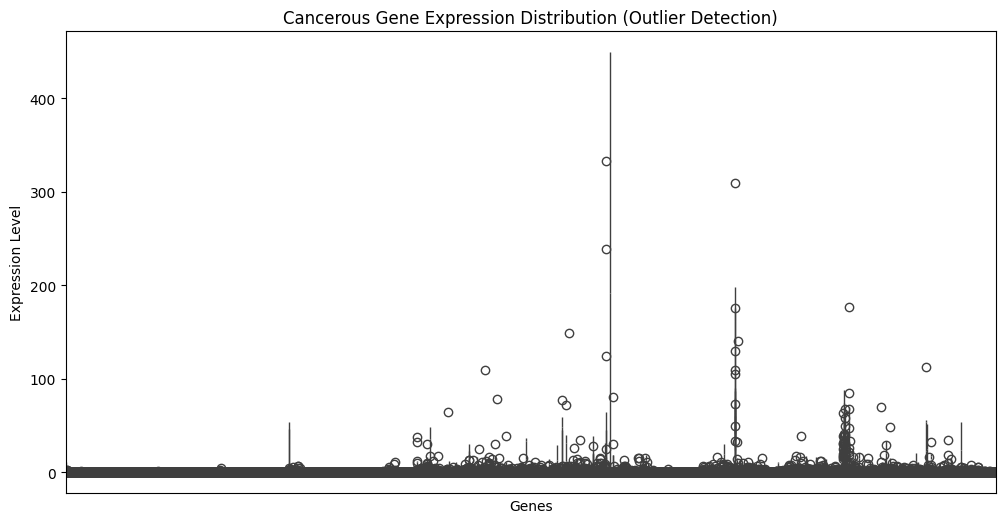

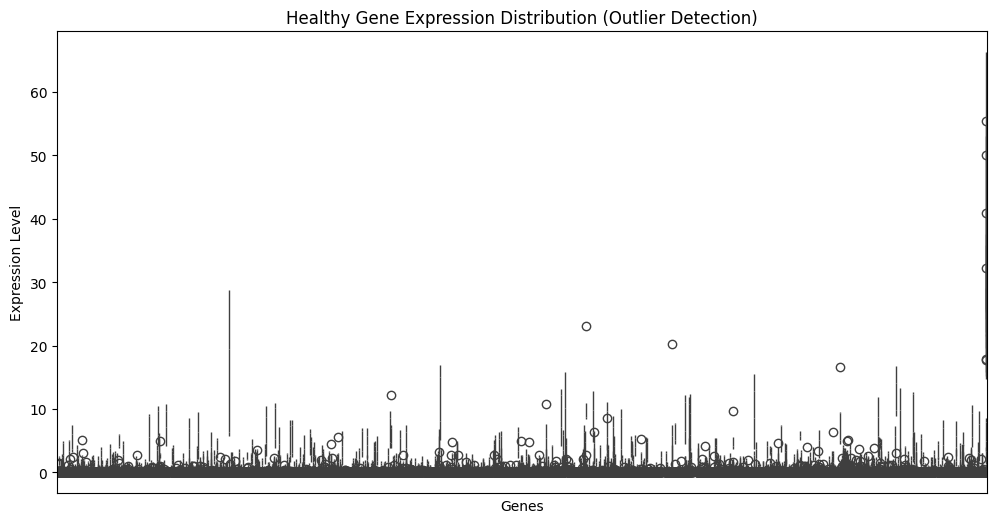

✅ Outliers successfully detected and visualized!


In [31]:



# Function to detect outliers row-by-row
def detect_outliers(df):
    """
    Identifies outliers using the IQR method.
    
    Instead of processing the entire DataFrame at once, it processes each row separately
    to avoid excessive memory usage.
    """
    outliers = pd.DataFrame(False, index=df.index, columns=df.columns)  # Initialize empty DataFrame

    for idx in df.index:  # Iterate row-wise
        row = df.loc[idx]
        Q1 = np.percentile(row, 25)
        Q3 = np.percentile(row, 75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers.loc[idx] = (row < lower_bound) | (row > upper_bound)  # Row-wise operation

    return outliers

# Detect outliers in cancerous and healthy data
cancerous_outliers = detect_outliers(cancerous_per_slide)
healthy_outliers = detect_outliers(healthy_per_slide)

# Count the number of outlier values per gene
cancerous_outlier_counts = cancerous_outliers.sum(axis=1)
healthy_outlier_counts = healthy_outliers.sum(axis=1)

# Visualize outlier detection using box plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=cancerous_per_slide.T, color="red")
plt.title("Cancerous Gene Expression Distribution (Outlier Detection)")
plt.xlabel("Genes")
plt.ylabel("Expression Level")
plt.xticks([])
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=healthy_per_slide.T, color="green")
plt.title("Healthy Gene Expression Distribution (Outlier Detection)")
plt.xlabel("Genes")
plt.ylabel("Expression Level")
plt.xticks([])
plt.show()

print("✅ Outliers successfully detected and visualized!")

# Downregulated Genes in Tumor

In [32]:
cancerous_file = "../../data/gene_analyses/brain/gen_exp_avg/cancerous_avg_gene_expression.csv"
healthy_file = "../../data/gene_analyses/brain/gen_exp_avg/healthy_avg_gene_expression.csv"

# Load the cancerous and healthy gene expression DataFrames
average_cancerous_genes_df = pd.read_csv(cancerous_file)
average_healthy_genes_df = pd.read_csv(healthy_file)

### 1. Which genes are Zeros in cancerous tissues but Active in healthy ones?


# 2. Which genes activite decreaces after the tummor ? 

* #### Filtering and Saving Cancer-Absent Gene Expressions

I know that this genes is zero in the Cancerious Slices so i need to know what is its activity in the healty ones.


In [33]:
min_healthy_value = healthy_per_slide[healthy_per_slide > 0].min().min()
print(f"🧬 The minimum non-zero gene expression value in healthy samples is: {min_healthy_value}")


🧬 The minimum non-zero gene expression value in healthy samples is: 0.0002169197396963


In [34]:
len(selected_cancerous_genes_df)

2075

In [35]:
output_dir = "../../data/gene_analyses/brain/gene_activity"

# Ensure "Gene" column is clean
selected_cancerous_genes_df["Gene"] = (
    selected_cancerous_genes_df["Gene"].replace("", np.nan).dropna()
)

# Fetch values, keeping NaNs for missing genes
cancer_absent_gene_expressions = healthy_per_slide.reindex(
    selected_cancerous_genes_df["Gene"], fill_value=np.nan
)

# Convert values to numeric (ignore errors)
cancer_absent_gene_expressions = cancer_absent_gene_expressions.apply(
    pd.to_numeric, errors="coerce"
)

# Determine noise threshold
noise_threshold = 0.01

# Apply noise filtering (keep values >= noise_threshold)
filtered_cancerous_gene_expressions = cancer_absent_gene_expressions[
    cancer_absent_gene_expressions >= noise_threshold
]
# Reset index to keep "Gene" as a separate column
filtered_cancerous_gene_expressions = filtered_cancerous_gene_expressions.reset_index()

# Drop rows where all values are NaN
filtered_cancerous_gene_expressions = filtered_cancerous_gene_expressions.dropna(how="all")

# Rename the index column to "Gene"
filtered_cancerous_gene_expressions.rename(columns={"index": "Gene"}, inplace=True)

# Save results with "Gene" column included
filtered_cancerous_gene_expressions.to_csv(
    f"{output_dir}/cancer_absent_gene_expressions.csv", index=False
)

print(f"""✅ Filtered gene expression data saved!
🔹 Noise threshold applied: {noise_threshold}
🔹 Total genes retained after filtering: {filtered_cancerous_gene_expressions.shape[0]}
""")

✅ Filtered gene expression data saved!
🔹 Noise threshold applied: 0.01
🔹 Total genes retained after filtering: 2075



In [36]:
len(selected_healthy_genes_df)

3658

In [37]:
filtered_cancerous_gene_expressions = pd.DataFrame(filtered_cancerous_gene_expressions)


In [38]:
filtered_cancerous_gene_expressions.describe()

,GSE184510_GSM5591750,GSE184510_GSM5591752,Human_Brain_Kwon_10162023_Visium_V10A27004_D1_Br3880,Human_Brain_Louise_02152023_Visium_Br3942_post,Human_Brain_Louise_02152023_Visium_Br6432_post,Human_Brain_Louise_02152023_Visium_Br8325_mid
count,515.000000,490.000000,131.000000,388.000000,415.000000,165.000000
mean,0.031064,0.033303,0.019650,0.034971,0.032211,0.026473
std,0.033168,0.041722,0.011777,0.047966,0.039012,0.020559
min,0.010116,0.010060,0.010195,0.010000,0.010045,0.010096
25%,0.013006,0.012877,0.011931,0.012955,0.013336,0.012260
50%,0.018064,0.018712,0.014967,0.020455,0.019397,0.018990
75%,0.032876,0.033803,0.023644,0.036875,0.033772,0.031490
max,0.250723,0.527565,0.076356,0.590455,0.423277,0.118990


In [39]:
output_dir = "../../data/gene_analyses/brain/gene_activity"

# Ensure "Gene" column is clean
selected_healthy_genes_df["Gene"] = (
    selected_healthy_genes_df["Gene"].replace("", np.nan).dropna()
)

# Fetch values, keeping NaNs for missing genes
healthy_absent_gene_expressions = cancerous_per_slide.reindex(
    selected_healthy_genes_df["Gene"], fill_value=np.nan
)

# Convert values to numeric (ignore errors)
healthy_absent_gene_expressions = healthy_absent_gene_expressions.apply(
    pd.to_numeric, errors="coerce"
)

# Determine noise threshold
noise_threshold = 0.01

# Apply noise filtering (keep values >= noise_threshold)
filtered_healthy_gene_expressions = healthy_absent_gene_expressions[
    healthy_absent_gene_expressions >= noise_threshold
]

# Reset index to keep "Gene" as a separate column
filtered_healthy_gene_expressions = filtered_healthy_gene_expressions.reset_index()

# Drop rows where all values are NaN
filtered_healthy_gene_expressions = filtered_healthy_gene_expressions.dropna(how="all")

# Rename the index column to "Gene"
filtered_healthy_gene_expressions.rename(columns={"index": "Gene"}, inplace=True)

# Save results with "Gene" column included
filtered_healthy_gene_expressions.to_csv(
    f"{output_dir}/healthy_absent_gene_expressions.csv", index=False
)
# print(filtered_healthy_gene_expressions)

# Display results
print(f"""✅ Filtered healthy gene expression data saved!
🔹 Noise threshold applied: {noise_threshold}
🔹 Total healthy genes retained after filtering: {filtered_healthy_gene_expressions.shape[0]}
""")


✅ Filtered healthy gene expression data saved!
🔹 Noise threshold applied: 0.01
🔹 Total healthy genes retained after filtering: 3658



In [40]:
# Ensure numeric data by setting the first column as index (assuming it contains gene names)
filtered_cancerous_gene_expressions.set_index("Gene", inplace=True)

# Convert to numeric (ignoring errors in case of non-numeric data)
filtered_cancerous_gene_expressions = filtered_cancerous_gene_expressions.apply(pd.to_numeric, errors="coerce")

# Get the top 10 genes with the highest expression values
top_10_genes = filtered_cancerous_gene_expressions.max(axis=1).nlargest(10)

# Display the result
print(top_10_genes)

Gene
NPAS4         0.590455
CARTPT        0.527565
FRMPD2        0.381364
OLFM3         0.250723
NGB           0.241851
DLGAP1-AS4    0.229650
CALB1         0.216499
NLGN4Y        0.214957
CCKBR         0.198409
PLPPR3        0.197727
dtype: float64


In [41]:
# Ensure the gene names are in the index (if not already)
filtered_healthy_gene_expressions.set_index("Gene", inplace=True)


# Convert to numeric (ignoring errors in case of non-numeric data)
filtered_healthy_gene_expressions = filtered_healthy_gene_expressions.apply(pd.to_numeric, errors="coerce")

# Get the top 10 genes with the highest expression values across all samples
top_10_genes = filtered_healthy_gene_expressions.max(axis=1).nlargest(10)

# Display the result
print(top_10_genes)


Gene
IGHG4     332.945549
IGHG3     238.495739
MUCL1     140.140700
IGHG1     124.443473
IGLC2      80.633450
S100A7     47.083047
PMEL       38.431818
SAA1       33.913713
IGLC3      30.733100
S100P      26.434944
dtype: float64


### What I think about
The "filtered_gene_expressions" _-The data is saved in the file called cancer_absent_gene_expressions -_ may represent tumor suppressor genes, as their expression decreases to zero in cancerous slides. These genes are referred to as "cancer-suppressed genes."

To verify this hypothesis, we need to investigate whether the identified genes are truly tumor suppressor genes or if they are just noise. This can be done by cross-referencing them with known tumor suppressor gene databases and analyzing their statistical significance.



### Comment and Observation 
I have 1,020 genes that are completely inactive (0 expression) in cancerous samples but have an activity level greater than 0.01 in healthy slides. However, the maximum expression for these genes does not exceed 0.2, which raises concerns about their significance. Since their expression levels are relatively low, they might not have a meaningful impact on our analysis. It is possible that these genes are not biologically relevant to our study’s objectives, especially if they are close to the noise threshold.

<!-- ### Step 2: Identify Highly Active and Moderately Changed Genes

In this step, we compare the average gene expression in cancerous and healthy tissues using the **fold-change approach**. We classify genes into three categories:

- **Highly Active Genes**: Genes with at least **2×** higher expression in cancerous tissues compared to healthy tissues.
- **Moderately Changed Genes**: Genes with a fold-change between **1× and 2×**.
- **Low-Activity Genes**: Genes with lower expression in cancerous tissues than in healthy ones.

This categorization helps us focus on genes that may play a significant role in cancer progression. The results are stored in separate files for further analysis. -->


In [42]:
c_gen_avg=pd.read_csv("../../data/gene_analyses/brain/gen_exp_avg/cancerous_avg_gene_expression.csv")


In [43]:
c_gen_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38224 entries, 0 to 38223
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            38224 non-null  object 
 1   Cancerous_Expression  38224 non-null  float64
dtypes: float64(1), object(1)
memory usage: 597.4+ KB


In [44]:
c_gen_avg.isna().sum()

Unnamed: 0              0
Cancerous_Expression    0
dtype: int64

In [46]:
c_gen_avg[(c_gen_avg["Cancerous_Expression"]==0)].count()

Unnamed: 0              10352
Cancerous_Expression    10352
dtype: int64

In [47]:
h_gen_avg=pd.read_csv("../../data/gene_analyses/brain/gen_exp_avg/healthy_avg_gene_expression.csv")


In [48]:
len(h_gen_avg)

36601

In [49]:
h_gen_avg.isna().sum()

Unnamed: 0            0
Healthy_Expression    0
dtype: int64

In [50]:
h_gen_avg[(h_gen_avg["Healthy_Expression"]==0)].count()

Unnamed: 0            9786
Healthy_Expression    9786
dtype: int64

In [114]:
output_dir = "../../data/gene_analyses/brain/gene_activity"


In [115]:
# Load low-change genes file
low_active_genes = pd.read_csv(f"{output_dir}/categorized_genes/low_change_genes.csv")

# Sort by Fold Change (ascending order)
sorted_inactive_in_cancer = low_active_genes.sort_values(by="Healthy_Expression", ascending=False)

# Drop genes present in selected_cancerous_genes_df
filtered_df = sorted_inactive_in_cancer[~sorted_inactive_in_cancer["Gene"].isin(selected_cancerous_genes_df["Gene"])]

# Overwrite the existing file
filtered_df.to_csv(f"{output_dir}/inactive_in_cancer_genes.csv", index=False)

# Display the updated list
display(filtered_df)

print(f"✅ Updated list saved in {output_dir}/inactive_in_cancer_genes.csv after removing selected cancerous genes.")


,Gene,Cancerous_Expression,Healthy_Expression,Fold_Change
13567,MTRNR2L12,7.732021,13.790272,0.560687
15939,SNAP25,0.476029,11.508679,0.041363
13916,NRGN,0.377407,10.929496,0.034531
13544,MT3,7.635190,10.136030,0.753272
10505,GNAS,7.274728,9.096342,0.799742
...,...,...,...,...
9507,DEFB103B,0.000000,0.000000,1.000000
9506,DEFB103A,0.000000,0.000000,1.000000
9537,DEFB4B,0.000000,0.000000,1.000000
9533,DEFB131B,0.000000,0.000000,1.000000


✅ Updated list saved in ../../data/gene_analyses/brain/gene_activity/inactive_in_cancer_genes.csv after removing selected cancerous genes.


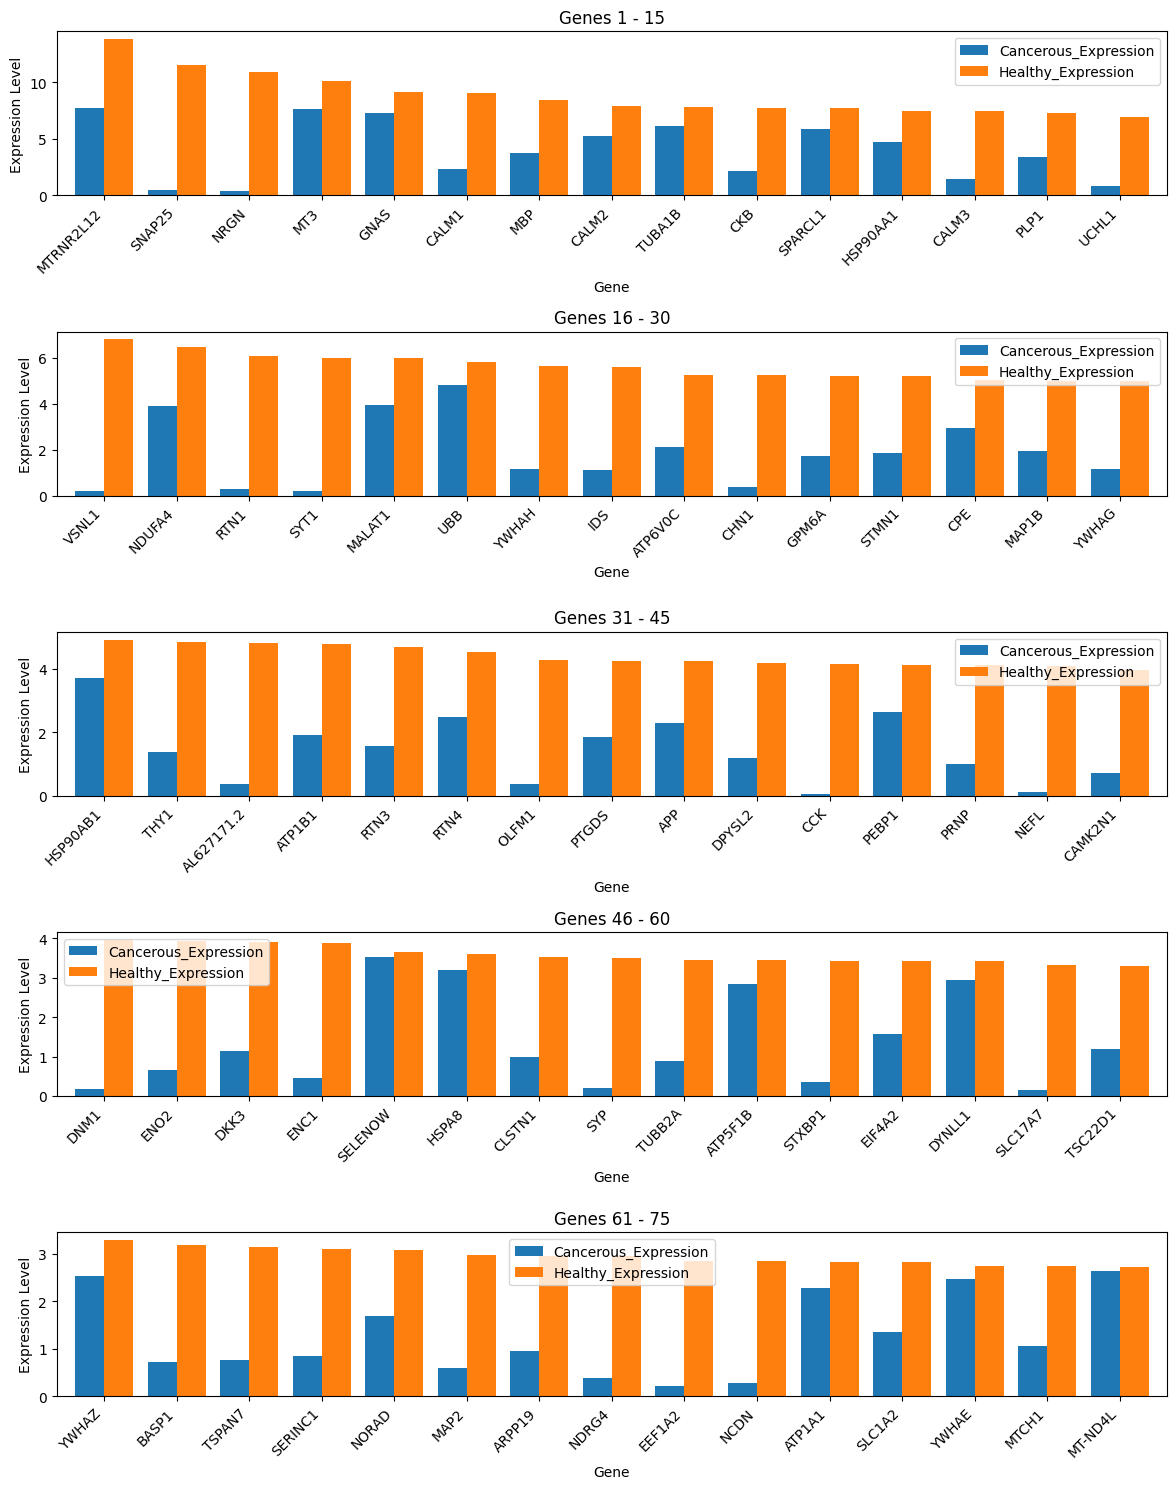

In [118]:

# Select the top 50 genes based on Healthy Expression
top_50_genes = sorted_inactive_in_cancer.head(90)

# Define subplot layout
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))

# Plot in 5 subplots (each with 10 genes)
for i in range(5):
    ax = axes[i]
    
    # Select 10 genes per subplot
    subset = top_50_genes.iloc[i * 15: (i + 1) * 15]
    
    # Bar plot
    subset.plot(
        x="Gene",
        y=["Cancerous_Expression", "Healthy_Expression"],
        kind="bar",
        ax=ax,
        width=0.8
    )
    
    # Titles and labels
    ax.set_ylabel("Expression Level")
    ax.set_title(f"Genes {i * 15 + 1} - {i * 15 + 15}")
    ax.set_xticklabels(subset["Gene"], rotation=45, ha="right")

# Adjust layout
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

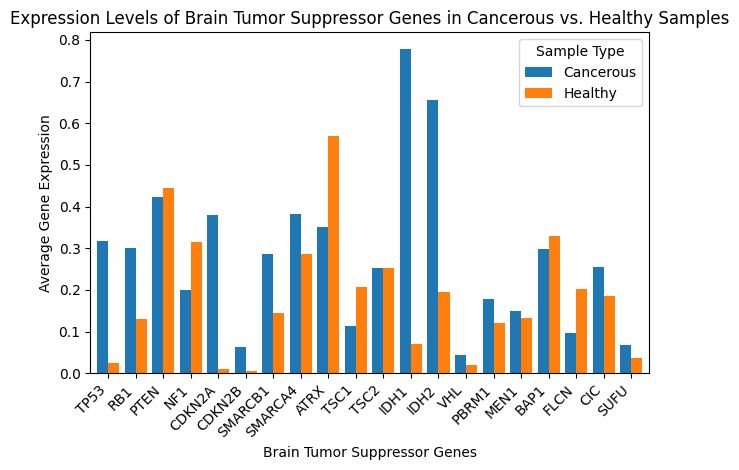

In [54]:
# List of brain tumor suppressor genes
brain_tumor_suppressor_genes = [
    "TP53", "RB1", "PTEN", "NF1", "CDKN2A", "CDKN2B", "SMARCB1", "SMARCA4",
    "ATRX", "TSC1", "TSC2", "IDH1", "IDH2", "VHL", "PBRM1", "MEN1", "BAP1",
    "FLCN", "CIC", "SUFU"
]

# Load datasets
cancerous_df = pd.read_csv(cancerous_file, index_col=0)
healthy_df = pd.read_csv(healthy_file, index_col=0)

# Filter for tumor suppressor genes
cancerous_genes = cancerous_df.loc[brain_tumor_suppressor_genes].dropna()
healthy_genes = healthy_df.loc[brain_tumor_suppressor_genes].dropna()

# Merge data for plotting
expression_data = pd.DataFrame({
    "Cancerous": cancerous_genes["Cancerous_Expression"],
    "Healthy": healthy_genes["Healthy_Expression"]
}).dropna()

# Plot bar graph
plt.figure(figsize=(12, 6))
expression_data.plot(kind='bar', width=0.8)
plt.ylabel("Average Gene Expression")
plt.xlabel("Brain Tumor Suppressor Genes")
plt.title("Expression Levels of Brain Tumor Suppressor Genes in Cancerous vs. Healthy Samples")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sample Type")
plt.tight_layout()
plt.show()


# 2. Which genes activite decreaces after the tummor ? 

In [55]:
sorted_inactive_in_cancer

,Gene,Cancerous_Expression,Healthy_Expression,Fold_Change
13307,MBD3L4,0.000000,0.000000,1.000000
7828,AP001180.4,0.000000,0.000000,1.000000
7863,AP001486.2,0.000000,0.000000,1.000000
13821,NLRP9,0.000000,0.000000,1.000000
13822,NMBR,0.000000,0.000000,1.000000
...,...,...,...,...
10505,GNAS,7.274728,9.096342,0.799742
13544,MT3,7.635190,10.136030,0.753272
13916,NRGN,0.377407,10.929496,0.034531
15939,SNAP25,0.476029,11.508679,0.041363


### 3. Which genes appear in both cancerous and healthy tissues but with different behaviors?


### 4. Are there genes in some cancerous tissues that also appear in some healthy ones?
If a gene is present in some healthy tissues but also in cancerous ones, it might be a pre-cancer indicator.


### 5. Are there "hidden" genes with subtle activity shifts that might indicate risk?



### 6. How do gene interactions change in cancerous vs. healthy tissues?



# Upregulated Genes in Tumor

## 2. Which genes are highly active in cancerous tissues but not in healthy ones?